## Setup

In [1]:
!pip install gym==0.25.2 pygame 

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration parameters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 10000
env = gym.make("CartPole-v1")  # Create the environment
env.seed(seed)
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0

2023-09-15 14:52:00.795416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-15 14:52:00.955508: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-15 14:52:00.993335: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-15 14:52:01.724851: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

## Environment

In [3]:
# Run a demo of the environment
observation = env.reset()
cum_reward = 0
cart_frames = []
for t in range(5000):
    # Render into buffer. 
    cart_frames.append(env.render(mode='rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)
    if done:
        break

/opt/conda/lib/python3.10/site-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


## Display

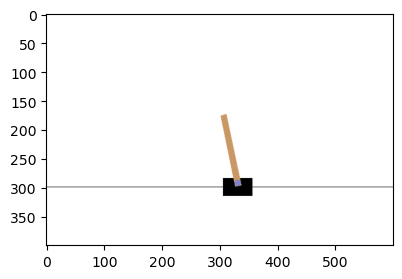

In [4]:
from matplotlib import animation, rc
rc('animation', html='jshtml')
fig, ax = plt.subplots(figsize = (5, 3))
im = ax.imshow(cart_frames[0])
def updatefig(frame):
    im.set_array(cart_frames[frame])
    return im,
anim = animation.FuncAnimation(fig, updatefig, 
                             frames = range(1, len(cart_frames)), interval=120, blit=True)
anim

## Network

In [5]:
num_inputs = 4
num_actions = 2
num_hidden = 128

inputs = layers.Input(shape=(num_inputs,))
common = layers.Dense(num_hidden, activation="relu")(inputs)
action = layers.Dense(num_actions, activation="softmax")(common)
critic = layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])

/opt/conda/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
2023-09-15 14:52:05.558942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-15 14:52:05.595026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-15 14:52:05.595303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-15 14:52:05.596335: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAP

## Training

In [6]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

while True:  # Run until solved
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
            # env.render(); Adding this line would show the attempts
            # of the agent in a pop up window.

            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])

            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # Apply the sampled action in our environment
            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward

            if done:
                break

        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 10 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(running_reward, episode_count))

    if running_reward > 195:  # Condition to consider the task solved
        template = "Solved at episode {} with reward {:.2f}!"
        print(template.format(episode_count, running_reward))
        break

running reward: 6.12 at episode 10
running reward: 8.07 at episode 20
running reward: 9.23 at episode 30
running reward: 11.22 at episode 40
running reward: 10.72 at episode 50
running reward: 11.63 at episode 60
running reward: 11.44 at episode 70
running reward: 11.21 at episode 80
running reward: 11.94 at episode 90
running reward: 13.20 at episode 100
running reward: 17.36 at episode 110
running reward: 20.55 at episode 120
running reward: 16.47 at episode 130
running reward: 14.10 at episode 140
running reward: 12.37 at episode 150
running reward: 11.70 at episode 160
running reward: 11.19 at episode 170
running reward: 11.06 at episode 180
running reward: 10.42 at episode 190
running reward: 9.99 at episode 200
running reward: 10.09 at episode 210
running reward: 10.77 at episode 220
running reward: 10.62 at episode 230
running reward: 10.55 at episode 240
running reward: 10.52 at episode 250
running reward: 11.85 at episode 260
running reward: 15.28 at episode 270
running reward

## Inference

In [7]:
cart_frames2 = []
episode_count = 0
while True:  # Run until solved
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
            # env.render(); Adding this line would show the attempts
            # of the agent in a pop up window.
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)

            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))

            # Apply the sampled action in our environment
            cart_frames2.append(env.render(mode='rgb_array'))
            state, reward, done, _ = env.step(action)
            episode_reward += reward

            if done:
                break

        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward


    if running_reward > 190:  # Condition to consider the task solved
        template = "Episode {} with reward {:.2f}!"
        print(template.format(episode_count, running_reward))
        break

/opt/conda/lib/python3.10/site-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Episode 0 with reward 208.22!


## Display

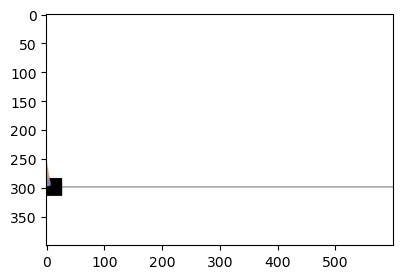

In [8]:
from matplotlib import animation, rc
rc('animation', html='jshtml')
fig, ax = plt.subplots(figsize = (5, 3))
im = ax.imshow(cart_frames2[0])
def updatefig(frame):
    im.set_array(cart_frames2[frame])
    return im,
anim = animation.FuncAnimation(fig, updatefig, 
                             frames = range(1, len(cart_frames2)), interval=120, blit=True)
anim